 # FIT5202 Assignment 1
 **Haichen Wang** <br>
 **29212634**
 <br>
 Notice: some cells depends on previous variables. Please run cells one by one downwards to avoid exceptions.

 ## Part B: Analysing CSV Data
 Analyze crime data from South Australia. The dataset reflects reported incidents of crime (suburb-based crime statistics for crimes against the person and crimes against property.) that occurred in South Australia since 2010.

### Step 01: Import `pyspark` and initialize Spark

In [1]:
# import pyspark and configure mongodb connection
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
from pyspark import SparkContext
from pyspark.sql import SparkSession

# Initialise a spark session, configure MongoDB connection
sc = SparkContext.getOrCreate()
if (sc is None):
    sc = SparkContext(master="local[*]")
spark = SparkSession(sparkContext=sc).builder.appName("Assignment 1 Part B")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.assignment1")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.assignment1")\
        .getOrCreate()

### Step 02: Create Dataframe
Write the code to create a data frame and provide the data source as the CSV file.<br>
How many records are there in the data frame? 

In [2]:
# create a data frame and load data from the CSV file
df = spark.read.csv('Datasets/Crime_Statistics_SA_2010_present.csv',inferSchema=True, header=True)

print("Total Records: {}".format(df.count()))

Total Records: 727408


### Step 03: Write to Database
Read the CSV file using spart session and insert all the records into MongoDB in `override` mode.

In [3]:
# write data frame to mongoDB
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

### Step 04: Read from Database
Create a Spark DataFrame to hold data from the MongoDB collection specified in the `spark.mongodb.input.uri` option which your SparkSession option is using. Display the schema of the data frame

In [4]:
# read data from momgoDB
df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### Step 05: Calculate the statistics of numeric and string columns
Calculate the statistics of "Offence Count" and "Reported Date". <br> Find the count, mean, standard deviation, minimum and maximum for these attributes. <br>Explain with reasoning whether the minimum and maximum reported date is correct.

In [5]:
# select 'Offence Count','Reported Date' to discribte atrributes
df_select = df.select('Offence Count','Reported Date')
df_select.describe().show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            727407|       727407|
|   mean|1.1715174585892079|         null|
| stddev| 0.578705093037808|         null|
|    min|                 1|    1/01/2011|
|    max|                28|    9/12/2018|
+-------+------------------+-------------+



**Analysis** <br>
The minimum and maximum reported date is incorrect.<br> Since the input data type is string, spark compares the value as numbers from left to right but not as Datetype. <br> For example, 1/01/2011 will be regarded as smaller than 8/12/2010

### Step 06: Change the data type of a column
The `Date` column is in string format. You need to change it to date format using the user-defined functions (udf).

In [6]:
# import essential libraries for data manipulating
from datetime import datetime
from pyspark.sql.functions import udf,col
from pyspark.sql.types import DateType

# function to convert string date to datetype
def map_to_date(str_date):
    return datetime.strptime(str_date,'%d/%m/%Y')

# define map_to_date as a Spark UDF and specify the data type as Spark DateType
myudf = udf(map_to_date, DateType())

# replace the old column with Date type value
df_modified = df.dropna(how='any').withColumn("Reported Date", myudf(col("Reported Date")))

In [7]:
df_modified.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### Step 07: Preliminary data analysis
Write the code to answer the following analytical queries.  
- How many level 2 offences are there? Display the list of level 2 offences.  
- What is the number of offences against the person?  
- How many serious criminal tresspasses with more than 1 offence count?  
- What percentage of crimes are offences against the property? 

In [8]:
# Q: How many level 2 offences are there? Display the list of level 2 offences.

# select distinct Offence Level 2 
df_select = df.select("Offence Level 2 Description").dropna(how='any').distinct()
print("Level 2 offences: {}".format(df_select.count()))

# list of level 2 offences
df_select.show()

Level 2 offences: 9
+---------------------------+
|Offence Level 2 Description|
+---------------------------+
|       ROBBERY AND RELAT...|
|       PROPERTY DAMAGE A...|
|       SEXUAL ASSAULT AN...|
|       HOMICIDE AND RELA...|
|       ACTS INTENDED TO ...|
|       SERIOUS CRIMINAL ...|
|       OTHER OFFENCES AG...|
|       FRAUD DECEPTION A...|
|       THEFT AND RELATED...|
+---------------------------+



In [9]:
# Q: What is the number of offences against the person?

# group by Offence Level 1 to count the total number of offence
df_sum = df.filter(col("Offence Level 1 Description") == 'OFFENCES AGAINST THE PERSON')\
    .groupBy("Offence Level 1 Description")\
    .sum("Offence Count").withColumnRenamed("sum(Offence Count)", "Number of Offences")
df_sum.show()

+---------------------------+------------------+
|Offence Level 1 Description|Number of Offences|
+---------------------------+------------------+
|       OFFENCES AGAINST ...|            175644|
+---------------------------+------------------+



In [10]:
# Q: How many serious criminal tresspasses with more than 1 offence count?

# filter records with conditions to count serious criminal tresspasses
df_sum = df.filter((col("Offence Level 2 Description") == 'SERIOUS CRIMINAL TRESPASS') & (col("Offence Count")>1))
tresspass_count = df_sum.count()
print("Tresspasses more than 1 offence count: {}".format(tresspass_count))

Tresspasses more than 1 offence count: 8579


In [11]:
# Q: What percentage of crimes are offences against the property?

# count the amount of offences against property
# collect()[0][0] - parse <DataFrame[bigint]> into <bigint>
num_offence_against_property = df.filter(col("Offence Level 1 Description") == 'OFFENCES AGAINST PROPERTY')\
.groupBy().sum("Offence Count").collect()[0][0]

# count all offences
num_offence_all = df.groupBy().sum("Offence Count").collect()[0][0]

print("Offences Against Property: {}".format(num_offence_against_property))
print("Offences Total: {}".format(num_offence_all))
print('Percentage of crimes are offences against the property: {:.2%}'.format(num_offence_against_property/num_offence_all))

Offences Against Property: 676526
Offences Total: 852170
Percentage of crimes are offences against the property: 79.39%


### Step 08: Exploratory data analysis  

Q1. Find the number of crimes per year. Plot the graph and explain your understanding                             of the graph

In [12]:
# from pyspark.sql.functions import date_format for data manipulation
from pyspark.sql.functions import year, month, dayofyear, dayofmonth, dayofweek
# import calendar for date transformation
import calendar

# import libraries for visualization
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# convert datetype as year
# group by year to sum up offence count
df_year_count = df_modified\
    .withColumn("Reported Year", year(col("Reported Date")))\
    .groupBy("Reported Year")\
    .sum("Offence Count")\
    .withColumnRenamed("sum(Offence Count)", "Offence Count")\
    .orderBy("Reported Year")

df_year_count.show()

+-------------+-------------+
|Reported Year|Offence Count|
+-------------+-------------+
|         2010|        61382|
|         2011|       122176|
|         2012|       112953|
|         2013|       106761|
|         2014|       101727|
|         2015|       105628|
|         2016|       107566|
|         2017|        50144|
|         2018|        55570|
|         2019|        27753|
+-------------+-------------+



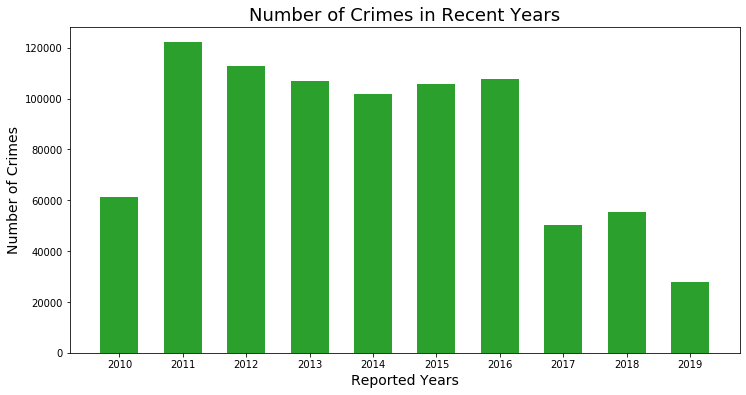

In [14]:
# prepare data
year_count = df_year_count.collect()
x = [year for year, count in year_count]
y = [count for year, count in year_count]

# plot configuration
bar_width = 0.6
plt.figure(figsize=(12,6))
ticks = np.arange(min(x), max(x)+1, 1)
plt.bar(x, y, bar_width, color="C2")
plt.xticks(ticks)
plt.title('Number of Crimes in Recent Years', fontsize=18)
plt.xlabel('Reported Years', fontsize = 14)
plt.ylabel('Number of Crimes', fontsize = 14)

plt.show()

**Analysis** <br>
The year 2011 has the largest number of crimes over 120000. Afterwards, the crimes level kept steady from 2011 to 2016 and then dropped sharply to 50144 at 2017. Then it comes to the bottom as 27753 at 2019. <br>
**However**, when looking at the original data for details, the records in year 2010, 2017, 2018 and 2019 are not complete. And that is the main reason for the data unevenness.

Q2. Find the number of crimes per month. Plot the graph and explain your understanding of the graph

In [15]:
# convert datetype as year and month
# group by year and month to sum up offence count
df_month_count = df_modified\
    .withColumn("Reported Year", year(col("Reported Date")))\
    .withColumn("Reported Month", month(col("Reported Date")))\
    .groupBy("Reported Year", "Reported Month")\
    .sum("Offence Count")\
    .withColumnRenamed("sum(Offence Count)", "Offence Count")\
    .orderBy("Reported Year", "Reported Month")

df_month_count.show()

+-------------+--------------+-------------+
|Reported Year|Reported Month|Offence Count|
+-------------+--------------+-------------+
|         2010|             7|         9886|
|         2010|             8|        10168|
|         2010|             9|        10017|
|         2010|            10|        10438|
|         2010|            11|        10390|
|         2010|            12|        10483|
|         2011|             1|        11103|
|         2011|             2|        10014|
|         2011|             3|        10669|
|         2011|             4|         9860|
|         2011|             5|        10356|
|         2011|             6|        10132|
|         2011|             7|        10118|
|         2011|             8|         9644|
|         2011|             9|         9704|
|         2011|            10|        10463|
|         2011|            11|        10103|
|         2011|            12|        10010|
|         2012|             1|        10442|
|         

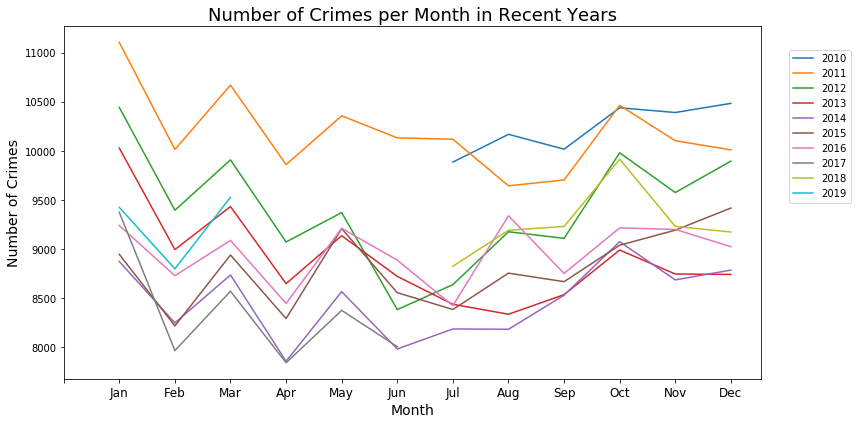

In [16]:
# prepare data
month_count = df_month_count.collect()
# collect a list of reported years in order
years_list = [ayear for ayear, count in year_count]
months_dict = {}
counts_dict = {}

# collect data for each year
for ayear in years_list:
    # create a list of months of the year
    months_per_year = [row["Reported Month"] for row in month_count if row["Reported Year"]==ayear]
    # create a list of offence counts of the year in the same order of months.
    counts_per_year = [row["Offence Count"] for row in month_count if row["Reported Year"]==ayear]
    # generate <year : months_list> and <year : offence_counts_list> pairs
    months_dict.update({ayear : months_per_year})
    counts_dict.update({ayear : counts_per_year})

# plot line graph
plt.figure(figsize=(12,6))

# add lines based on year
for ayear in years_list:
    plt.plot(months_dict[ayear], counts_dict[ayear], label='{}'.format(ayear))

# set x ticks for 12 months
ticks = range(0,13)
plt.xticks(ticks, calendar.month_abbr, fontsize=12)
plt.title('Number of Crimes per Month in Recent Years', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)
plt.legend(loc=(1.04,0.5))
plt.tight_layout()

plt.show()

**Analysis** <br>
This line graph demontrates the number of crimes for each month in recent years. It is consistent with the bar chart in question 1. <br>
Comparing with different years, the year 2011 was faced with the highest crime occurence. <br>
A trend is showed that the crime level in Jan, March and Oct tends to be roughly higher than other months over these years. <br>
It can also noticed that the records of 2010, 2017, 2018, 2019 are incomplete.

Q3. Where do most crimes take place? Find the top 20 suburbs (which would also display postcode for e.g. Caulfield-3162 )?. Plot the graph and explain your understanding of the graph.

In [17]:
# group by suburb and postcode to sum up offence count
df_suburb_count = df.filter(col("Suburb - Incident") != "NOT DISCLOSED")\
    .groupBy("Suburb - Incident", "Postcode - Incident")\
    .sum("Offence Count")\
    .withColumnRenamed("Suburb - Incident", "Suburb")\
    .withColumnRenamed("Postcode - Incident", "Postcode")\
    .withColumnRenamed("sum(Offence Count)", "Offence Count")\
    .orderBy("Offence Count", ascending = False)

df_suburb_count.show(20)

+-----------------+--------+-------------+
|           Suburb|Postcode|Offence Count|
+-----------------+--------+-------------+
|         ADELAIDE|    5000|        46701|
|     PORT AUGUSTA|    5700|        13711|
|    MOUNT GAMBIER|    5290|        13709|
|    MURRAY BRIDGE|    5253|        12919|
|    MORPHETT VALE|    5162|        12569|
|        SALISBURY|    5108|        10806|
|     PORT LINCOLN|    5606|        10779|
|        ELIZABETH|    5112|        10731|
|     DAVOREN PARK|    5113|         8082|
|PARAFIELD GARDENS|    5107|         8040|
|    OAKLANDS PARK|    5046|         7792|
|        PARALOWIE|    5108|         7261|
|         PROSPECT|    5082|         7234|
|       PORT PIRIE|    5540|         7155|
|          MODBURY|    5092|         7041|
|       SMITHFIELD|    5114|         7000|
|  SALISBURY NORTH|    5108|         6538|
|   WHYALLA STUART|    5608|         6297|
|     MAWSON LAKES|    5095|         6103|
|   WHYALLA NORRIE|    5608|         5837|
+----------

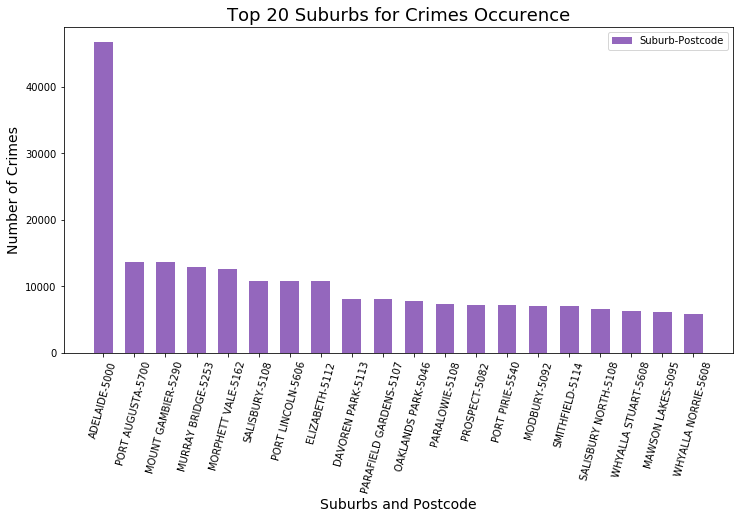

In [18]:
# prepare data
# collect list of suburb-postcode and the corresponding offence count
suburb_count = df_suburb_count.take(20)
x = [row["Suburb"]+'-'+ row["Postcode"] for row in suburb_count]
y = [row["Offence Count"] for row in suburb_count]

# plot configuration
plt.figure(figsize=(12,6))
plt.bar(x, y, width=0.6, label="Suburb-Postcode", color="C4")
plt.xticks(rotation=75)
plt.title('Top 20 Suburbs for Crimes Occurence', fontsize=18)
plt.xlabel('Suburbs and Postcode', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)
plt.legend()

plt.show()

**Analysis** <br>
ADELAIDE-5000 has the largest number of crimes as 46701, which is even the triple of each other top suburbs. <br>
The other top 20 suburbs share a roughly equal occurence of crimes around 10000.

Q4. Find the number of serious criminal trespasses by day and month. Plot a graph and explain your understanding of the graph

In [19]:
# convert datetype as month and weekday
# group by date to show how many serious criminal trespasses occur 
df_weekday_count = df_modified\
    .filter(col("Offence Level 2 Description") == 'SERIOUS CRIMINAL TRESPASS')\
    .withColumn("Reported Month", month(col("Reported Date")))\
    .withColumn("Day of Week", dayofweek(col("Reported Date")))\
    .groupBy("Reported Month", "Day of Week")\
    .sum("Offence Count")\
    .withColumnRenamed("sum(Offence Count)", "Serious Criminal Trespasses")\
    .orderBy("Day of Week", "Reported Month")

df_weekday_count.show()

+--------------+-----------+---------------------------+
|Reported Month|Day of Week|Serious Criminal Trespasses|
+--------------+-----------+---------------------------+
|             1|          1|                       1309|
|             2|          1|                       1142|
|             3|          1|                       1310|
|             4|          1|                       1097|
|             5|          1|                       1138|
|             6|          1|                       1071|
|             7|          1|                       1334|
|             8|          1|                       1220|
|             9|          1|                       1293|
|            10|          1|                       1383|
|            11|          1|                       1328|
|            12|          1|                       1280|
|             1|          2|                       1720|
|             2|          2|                       1660|
|             3|          2|   

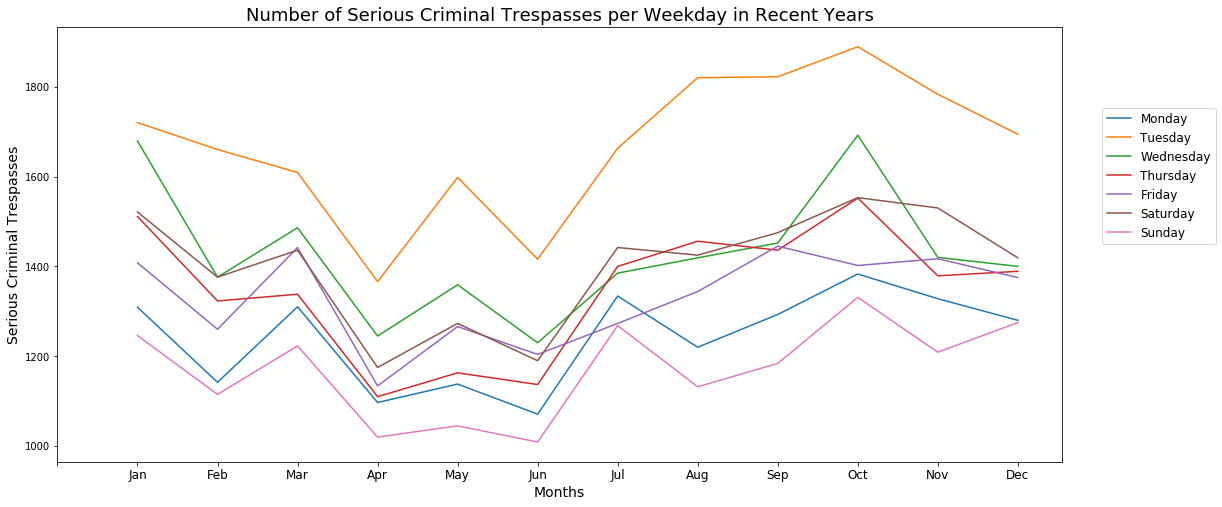

In [20]:
# collect data from dataframe
weekday_count = df_weekday_count.collect()
weekday_list = list(range(1,8))
month_list = list(range(1,13))
counts_dict = {}

# generate <weekday : trespasses_counts_list> pairs
for aday in weekday_list:
    counts_list = [row["Serious Criminal Trespasses"] for row in weekday_count if row["Day of Week"]==aday]
    counts_dict.update({aday : counts_list})

# plot line graph
plt.figure(figsize=(18,8))
# add lines to chart based on weekdays
for aday in weekday_list:
    plt.plot(month_list, counts_dict[aday], label='{}'.format(calendar.day_name[aday-1]))
# configure line chart
plt.xticks(range(0,13,1),calendar.month_abbr, fontsize = 12)
plt.title('Number of Serious Criminal Trespasses per Weekday in Recent Years', fontsize=18)
plt.xlabel('Months', fontsize=14)
plt.ylabel('Serious Criminal Trespasses', fontsize=14)
plt.legend(loc=(1.04,0.5), fontsize = 12)

plt.show()

**Analysis** <br>
This line chart demonstrates serious criminal trespasses occurence on each weekday. Data is calculated from different years. <br>
It can be seen that the offences counted on Tuesday are higher than other days. And Sunday has the lowest serious criminal level for these years. <br>

**Additional Approach**

In [21]:
# convert date to year and days
# group by date to sum up serious criminal trespasses
df_day_count = df_modified\
    .filter(col("Offence Level 2 Description") == 'SERIOUS CRIMINAL TRESPASS')\
    .withColumn("Reported Year", year(col("Reported Date")))\
    .withColumn("Day of Year", dayofyear(col("Reported Date")))\
    .groupBy("Reported Year", "Day of Year")\
    .sum("Offence Count")\
    .withColumnRenamed("sum(Offence Count)", "Serious Criminal Trespasses")\
    .orderBy("Reported Year", "Day of Year")

df_day_count.show()

+-------------+-----------+---------------------------+
|Reported Year|Day of Year|Serious Criminal Trespasses|
+-------------+-----------+---------------------------+
|         2010|        182|                         37|
|         2010|        183|                         41|
|         2010|        184|                         41|
|         2010|        185|                         39|
|         2010|        186|                         44|
|         2010|        187|                         38|
|         2010|        188|                         41|
|         2010|        189|                         41|
|         2010|        190|                         44|
|         2010|        191|                         53|
|         2010|        192|                         42|
|         2010|        193|                         57|
|         2010|        194|                         45|
|         2010|        195|                         40|
|         2010|        196|                     

In [22]:
# define a function which takes a list of years as parameter to plot line graphs 
# to show the trend of serious criminal trespasses counted in each day.

# Notice # 
# This function depends on a variable named as "year_count" which is delared in Step 8, Q1.
# Execute this code after previous cells

def trespasses_day_count(year_list):
    
    # if year_list contains a year that is not recorded, remove
    for ayear in year_list:
        if ayear not in [ayear for ayear, count in year_count]:
            year_list.remove(ayear)
    
    day_count = df_day_count.collect()
    days_dict = {}
    counts_dict = {}

    # generate <year : days_list> and <year : trespasses_counts_list> pairs
    for ayear in year_list:
        days_per_year = [row["Day of Year"] for row in day_count if row["Reported Year"]==ayear]
        counts_per_year = [row["Serious Criminal Trespasses"] for row in day_count if row["Reported Year"]==ayear]
        days_dict.update({ayear : days_per_year})
        counts_dict.update({ayear : counts_per_year})

    # plot line graph
    plt.figure(figsize=(18,8))
    # add lines based on year
    for ayear in year_list:
        plt.plot(days_dict[ayear], counts_dict[ayear], label='{}'.format(ayear))
    # set x ticks
    ticks = range(1,366,30)
    plt.xticks(ticks, fontsize=12)
    plt.title('Number of Serious Criminal Trespasses per Day in Recent Years', fontsize=18)
    plt.legend(loc='upper left', fontsize=12)
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('Serious Criminal Trespasses', fontsize=14)

    plt.show()

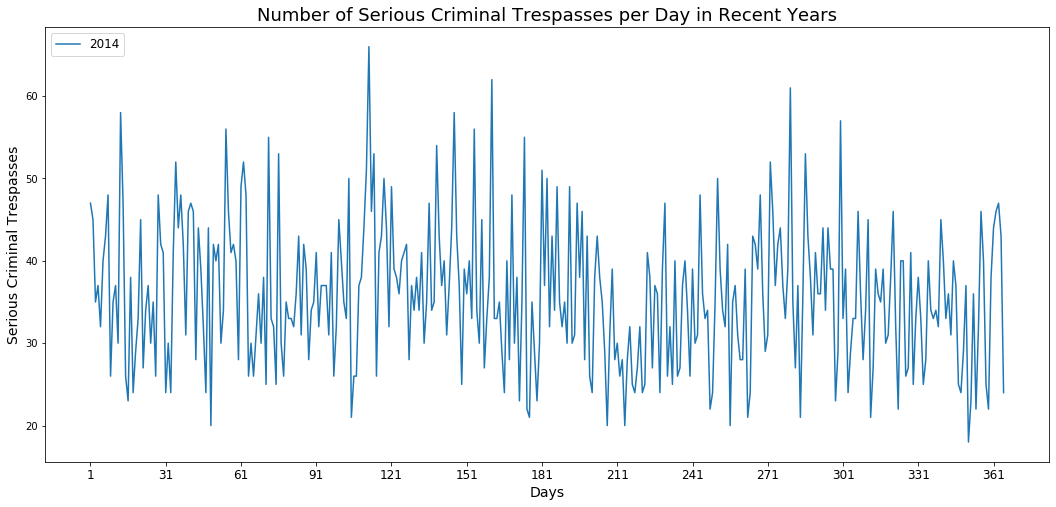

In [23]:
# modify the list [year, year, ...] to view results for specific years
years = [2014]

# uncomment to view results for all recorded years
# years = [year for year, count in year_count]

# show results
trespasses_day_count(years)

**Analysis** <br>
The Serious Criminal Trespasses records are not evenly distributed over time. The records varied in the range of 2 digits numbers per day for these years. <br>
The highest record was in the year 2010, almost 80 on that day.